Test ClassMakeFake to be sure its doing what we want.... 

In [1]:
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np

Expand by 1.00


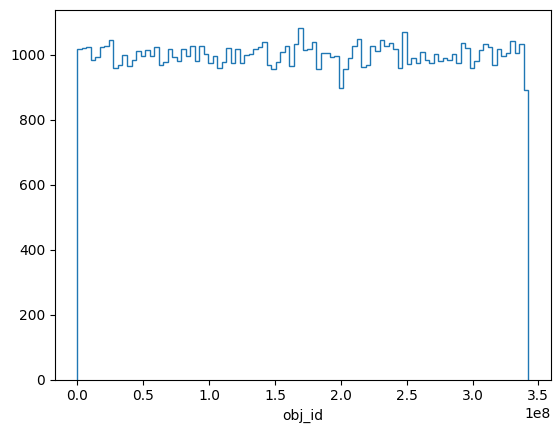

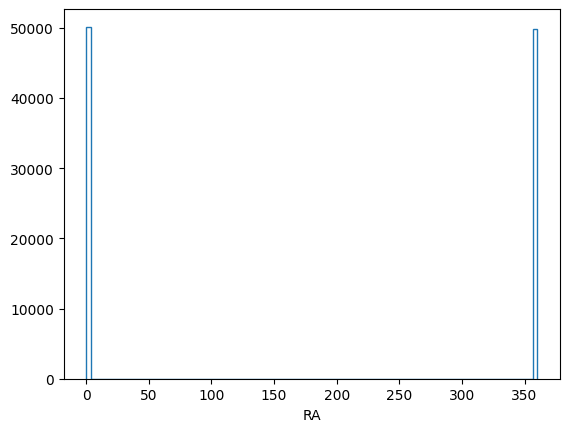

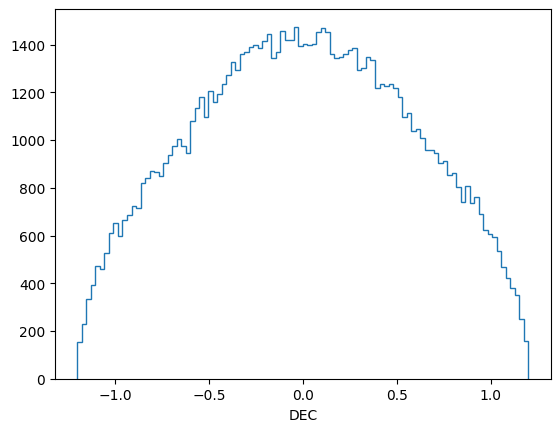

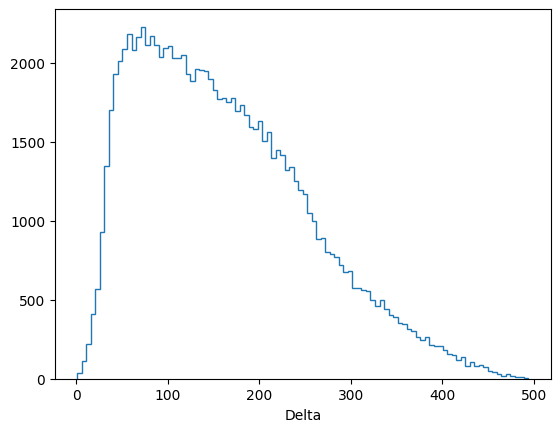

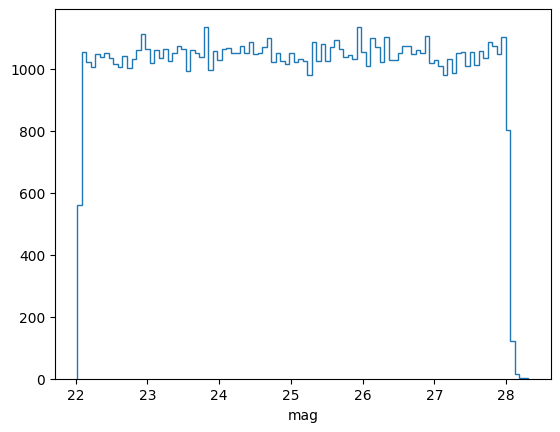

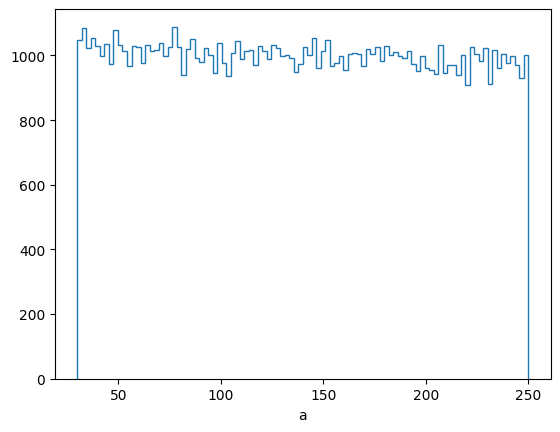

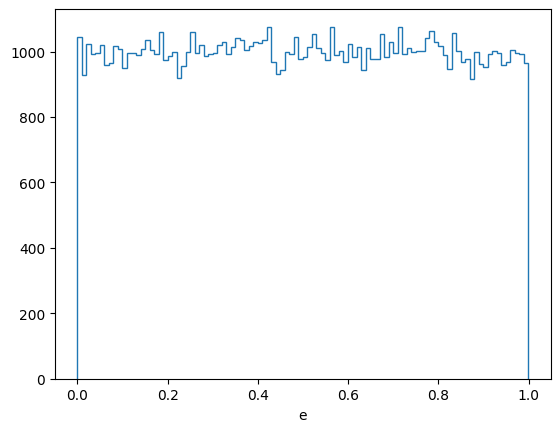

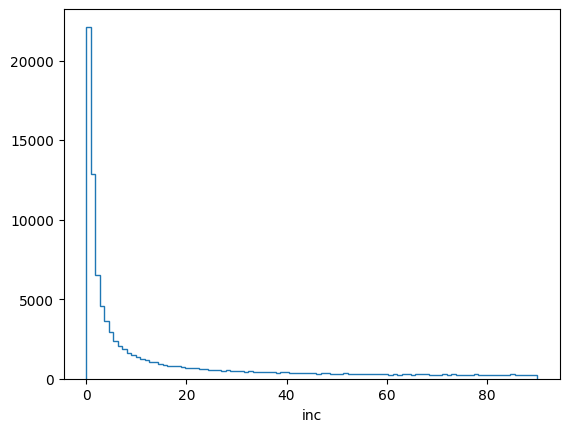

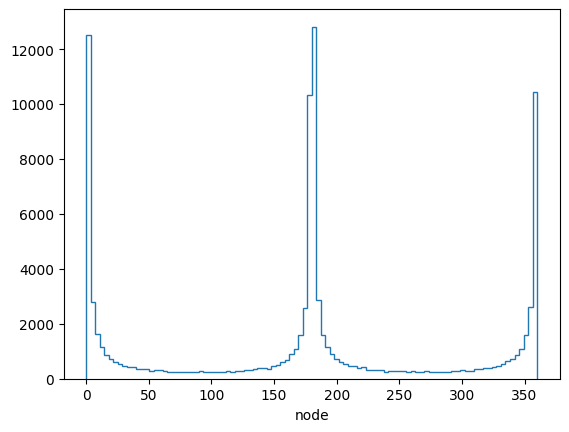

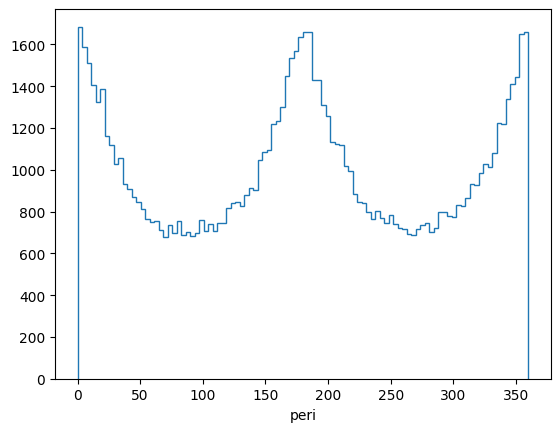

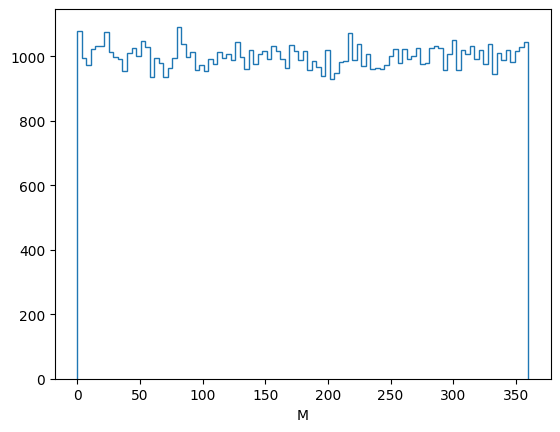

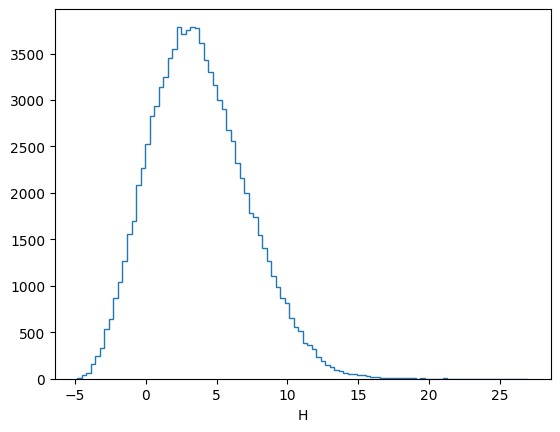

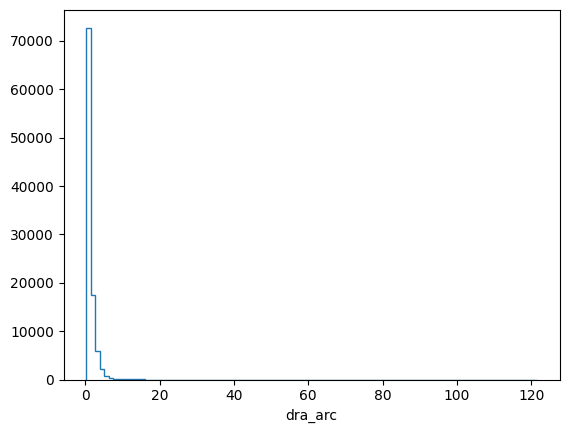

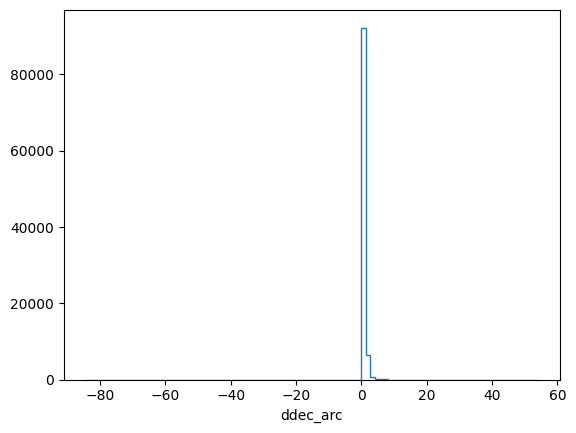

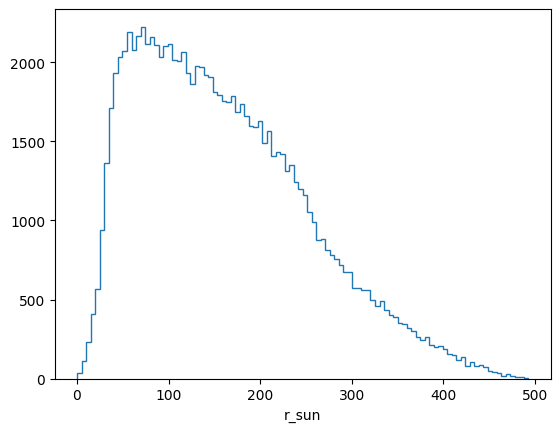

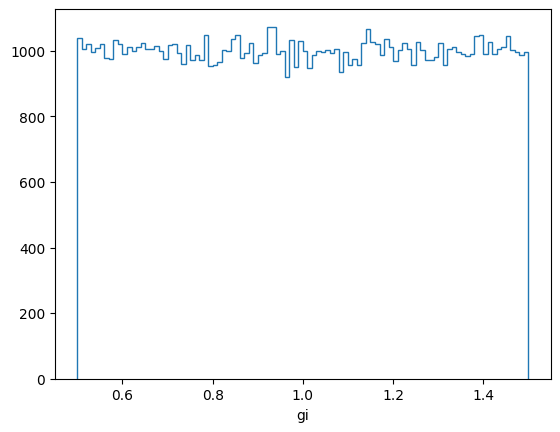

In [2]:
TestFile="PlantList_1_0.0000_0.0000_0.0000_.txt"
test_data = Table.read(TestFile, format='ascii')
cond = (test_data['a'] > 0) & (test_data['Delta']>0.0) & (test_data['e']>0)
print(f"Expand by {len(test_data)/cond.sum():4.2f}")
test_data = test_data[cond]

for column in test_data.colnames:
    d = plt.hist(test_data[column], bins=100, histtype='step')
    plt.xlabel(column)
    plt.show()

In [48]:
test_data[np.argmin(test_data['dra_arc'])]

obj_id,RA,DEC,Delta,mag,a,e,inc,node,peri,M,H,dra_arc,ddec_arc,r_sun,gi
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3760283,0.631036,0.606587,379.388976,26.603898,199.347284,0.929687,84.445392,0.849468,177.455844,208.534014,0.792209,0.325377,0.151551,378.473856,1.184704


1.020599913279625

'-368.19'

<re.Match object; span=(0, 8), match=' +1234.0'>


In [2]:
class TrackingFile(object):
    """
    Class to loop over tacking observation file from lassy.
    """
    #columns = "	x y dx dy mag mjd ra dec dra ddec".split()

    OBJ_MEASURE_COLUMNS = """
    chip
    index
    mjd
    x
    y
    dx
    dy
    mag
    likelihood
    ra
    dec
    dra
    ddec
    """.split()


    def __init__(self, filename):
        self.filename = filename
        self.fobj = open(filename, 'r')
        self._next_line = None


    @property
    def next_line(self):
        if self._next_line is None:
            self._next_line = self.fobj.readline()
        return self._next_line

    @property
    def field(self) -> str:
        return f"{self.filename.split('/')[-1][0:3]}"

    @property
    def obs_date(self) -> str:
        return re.search("(\d\d\d\d-\d\d-\d\d)",self.filename).group(0)

    def __iter__(self):
        return self

    def __next__(self):
        """Return the next 'object' from the kbmod input file"""

        _mea = self.next_line
        while _mea[0] == "#":
            self._next_line =  None
            _mea = self.next_line
        if _mea is None:
            raise StopIteration
        self._next_line = None
        _mea = _mea.split()


        m = {}
        for column in TrackingFile.OBJ_MEASURE_COLUMNS:
            v = _mea.pop(0)
            if "." in v:
                m[column] = float(v)
            else:
                try:
                    m[column] = int(v)
                except:
                    m[column] = v
        return m


In [3]:
class DetectionFile(object):
    """ er produces from kbomd outputs.
    """
    OBJ_START_LINE = re.compile('\s*(?P<id>\d+)\s+(?P<dist>\d+(\.\d*)?)\s+(?P<mag>\d+(\.\d*)?)\s+(?P<visit>\d+)\s+(?P<chip>\d+)\s+(?P<ndet>\d+)\s*')
    OBJ_MEASURE_LINE = re.compile("\s*(?P<x>[+-]?\d*(\.\d*)?)\s+(?P<y>[+-]?\d*(\.\d*)?)\s+(?P<dx>[+-]?\d*(\.\d*)?)\s+(?P<dy>[+-]?\d*(\.\d*)?)\s+(?P<mag>[+-]?\d*(\.\d*)?)\s+(?P<mjd>[+-]?\d*(\.\d*)?)\s+(?P<ra>[+-]?\d*(\.\d*)?)\s+(?P<dec>[+-]?\d*(\.\d*)?)\s+(?P<dra>[+-]?\d*(\.\d*)?\s)+(?P<ddec>[+-]?\d*(\.\d*)?)\s*")
    OBJ_MEASURE_LINE = re.compile("\s*(?P<x>\S+)\s+(?P<y>\S+)\s+(?P<dx>\S+)\s+(?P<dy>\S+)\s+(?P<mag>\S+)\s+(?P<mjd>\S+)\s+(?P<ra>\S+)\s+(?P<dec>\S+)\s+(?P<dra>\S+)\s+(?P<ddec>\S+)\s*")
    columns = "	x y dx dy mag mjd ra dec dra ddec".split()
    def __init__(self, filename):
        self.filename = filename
        self.fobj = open(filename, 'r')
        self._inobj = False
        self._next_line = None

    @property
    def next_line(self):
        if self._next_line is None:
            self._next_line = self.fobj.readline()
        return self._next_line
        
    def __iter__(self):
        return self

    def __next__(self):
        if not self._inobj:
            _obj = OBJ_START_LINE.match(self.next_line)
            if _obj is None:
                raise StopIteration
            else:
                self._inobj = True
                self._next_line = None
                ret_val = {}
                for column in _obj.groupdict().keys():
                    value = _obj.group(column)
                    op = int
                    if "." in value:
                        op = float
                    ret_val[column] = op(value)
                return ret_val
        else:
            _mea = self.next_line.strip().split()
            if len(_mea) != len(DetectionFile.columns):
                self._inobj = False
                raise StopIteration
            ret_val = {}
            for column in DetectionFile.columns:
                ret_val[column] = float(_mea.pop(0))
            self._next_line = None
            return ret_val
        


In [4]:
filename = "/arc/home/jkavelaars/classy_kbmo_outputs/AS2_ACTUAL.prelim_det"
# filename = "/arc/home/jkavelaars/classy_kbmo_outputs/AS1.prelim_det"
df = DetectionFile(filename)
for l in df:
    id = l['id']
    name = f"C{filename.split('/')[-1][0:3]}c{id:03d}"
    mag = l['mag']
    dt = 0
    obs = []
    for m in df:
        for dt in [0, 1.5, 3]:
            ra = m['ra'] + dt*m['dra']/(3600.0*np.cos(np.radians(m['dec'])))
            dec = m['dec'] + dt*m['ddec']/3600.0
            time = Time(m['mjd'], format='mjd') + dt/24.0
            obs.append(Observation(provisional_name=name,
                            mag=m['mag'],
                            xpos=m['x'],
                            ypos=m['y'],
                            ra=ra,
                            dec=dec,
                            band='r',
                            date=time,
                            observatory_code=568,
                            comment=f"V{l['visit']:02d}{l['chip']:03d} KBMOD OUT"))
        with open(f"{name}.mpc", 'w') as fobj:
            for ob in obs:
                fobj.write(ob.to_mpc()+"\n")
        orb = BKOrbit(obs)
        print(f"{name:10s} {orb.distance:4.1f} {orb.a*(1-orb.e):4.1f}")


NameError: name 'OBJ_START_LINE' is not defined

In [5]:
filename = "/arc/home/jkavelaars/classy_kbmo_outputs/AS1_2022-08-05_tracking.det"
tf = TrackingFile(filename)
with  open('AS1_20220805_tracking.ast', 'w') as result_file:
    for m in tf:
        name = f"{tf.field}{int(tf.obs_date[-2:]):02d}{m['chip']:02d}{m['index']:03d}"
        # create three measures per line using the rate info
        obss = []
        for dt in [0, 1.5, 3]:
            ra = m['ra'] + dt * m['dra'] / (3600.0 * np.cos(m['dec']))
            dec = m['dec'] + dt * m['ddec'] / 3600.0
            time = Time(m['mjd'], format='mjd') + dt / 24.0
            comment = f"{int(min(999, m['likelihood']))}"
            #print(comment)
            obs = Observation(provisional_name=name,
                                   mag=m['mag'],
                                   xpos=m['x'],
                                   ypos=m['y'],
                                   frame=f"{tf.obs_date.replace('-','')}c{m['chip']:02}",
                                   ra=ra,
                                   dec=dec,
                                   band='w',
                                   date=time,
                                   mag_err=0.5,
                                   observatory_code=568,
                                   comment=comment)
            result_file.write(obs.to_tnodb()+'\n')


IndexError: string index out of range

In [6]:
%pwd

'/arc/home/jkavelaars/classy-pipeline/classy/fortran_code'

In [166]:
%pwd

'/arc/home/jkavelaars/classy-pipeline/classy/fortran_code'

In [178]:
!tar cf /arc/home/jkavelaars/classy_kbmo_outputs/AS1_mpc_V2.tgz CAS1*.mpc

In [179]:
!tar cf /arc/home/jkavelaars/classy_kbmo_outputs/AS2_mpc_V2.tgz CAS2*.mpc